In [1]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Network_science')

### Retrieve references

I chose two papers on applications of causal inference, one in the biomedical field and one in physics. I was curious if these two fields will be connected if I retrieve deeper levels of references. I used the `pyalex` module which can recursively find the references of the two source papers, which were published relative recently, so only had about 1-5 citations. Starting with these two source is like starting from the edge of the literature network. To limit the size of my reference dataset for this assignment, only 3 levels of reference were included and the references were filtered with `publication_year="2020-2024"`.



In [ ]:
!pip install pyalex

In [ ]:
import pyalex
from pyalex import Works
import time

pyalex.config.email = "yingyu.mao@northwestern.edu"

In [ ]:
def fetch_recent_refs_recursive(doi, max_depth=1, current_depth=0):
    if current_depth > max_depth:
        return []

    print(f"{'  ' * current_depth}Searching DOI: {doi}...")

    try:
        work = Works()[f"https://doi.org/{doi}"]
    except Exception as e:
        print(f"{'  ' * current_depth}Error fetching initial work {doi}: {e}")
        return []

    referenced_ids = work.get('referenced_works', [])
    if not referenced_ids:
        return []

    try:
        recent_refs = (
            Works()
            .filter(openalex_id="|".join(referenced_ids))
            .filter(publication_year="2020-2024")
            .get()
        )
    except Exception as e:
        print(f"{'  ' * current_depth}Error fetching batch references for DOIs related to {doi}: {e}")
        time.sleep(5)
        return []


    results = []
    for ref in recent_refs:
        paper_info = {
            'source_doi': doi,
            'target_doi': ref.get('doi'),
            'title': ref.get('display_name'),
            'pub_date': ref.get('publication_date'),
            'id': ref.get('id').replace("https://openalex.org/", "")
        }
        results.append(paper_info)

        if paper_info['target_doi']:
            next_doi = paper_info['target_doi'].replace("https://doi.org/", "")
            results.extend(fetch_recent_refs_recursive(next_doi, max_depth, current_depth + 1))

    return results

doi_to_start = ["10.1093/aje/kwae338", "10.1038/s42005-025-02170-6"]

network_data = []
for doi in doi_to_start:
    network_data.extend(fetch_recent_refs_recursive(doi, max_depth=3))

Searching DOI: 10.1093/aje/kwae338...
  Searching DOI: 10.1093/ije/dyaa213...
    Searching DOI: 10.1093/ije/dyaa049...
      Searching DOI: 10.1201/9781003278290-44...
  Searching DOI: 10.1038/s41598-020-59669-x...
  Searching DOI: 10.2188/jea.je20190192...
  Searching DOI: 10.1093/aje/kwab087...
    Searching DOI: 10.1214/19-aos1857...
      Searching DOI: 10.1016/j.jeconom.2019.12.016...
  Searching DOI: 10.1177/25152459231156085...
    Searching DOI: 10.1037/met0000425...
    Searching DOI: 10.1016/j.jclinepi.2021.08.001...
      Searching DOI: 10.2188/jea.je20190192...
      Searching DOI: 10.1001/jamapediatrics.2020.3009...
      Searching DOI: 10.1016/j.jclinepi.2020.06.020...
      Searching DOI: 10.1093/ije/dyaa211...
    Searching DOI: 10.7554/elife.53275...
    Searching DOI: 10.2188/jea.je20190192...
    Searching DOI: 10.31219/osf.io/9em5q...
      Searching DOI: 10.1093/ije/dyaa213...
      Searching DOI: 10.1002/14651858.cd012880.pub2...
      Error fetching batch refere

In [ ]:
len(network_data)

4408

In [ ]:
with open('network_data.json', 'w') as f:
    json.dump(network_data, f, indent=4)

In [5]:
with open('network_data.json', 'r') as f:
    network_data = json.load(f)

In [6]:
network_data[0]

{'source_doi': '10.1093/aje/kwae338',
 'target_doi': 'https://doi.org/10.1093/ije/dyaa213',
 'title': 'Use of directed acyclic graphs (DAGs) to identify confounders in applied health research: review and recommendations',
 'pub_date': '2020-10-12',
 'id': 'W3114319529'}

I got 4408 citation events with information about the source paper and the target paper. To ingest this into a `networkx` graph, I need to organize the data into a dictionary containing nodes with attributes such as `title`, `pub_data`, `id`, etc. I used the unique doi of the papers as their node names.

In [7]:
unique_papers = {}
for item in network_data:
    target_doi = item.get('target_doi')
    if target_doi and target_doi.startswith('https://doi.org/'):
        target_doi = target_doi.replace('https://doi.org/', '')

    # Add source_doi to unique_papers
    source_doi = item.get('source_doi')
    if source_doi and source_doi not in unique_papers:
        unique_papers[source_doi] = {
            'title': None,
            'pub_date': None,
            'id': None
        }

    # Add target_doi and its attributes to unique_papers
    if target_doi and target_doi not in unique_papers:
        unique_papers[target_doi] = {
            'title': item.get('title'),
            'pub_date': item.get('pub_date'),
            'id': item.get('id')
        }
    elif target_doi and target_doi in unique_papers:
        # If the target_doi already exists, update any missing information
        if not unique_papers[target_doi]['title'] and item.get('title'):
            unique_papers[target_doi]['title'] = item.get('title')
        if not unique_papers[target_doi]['pub_date'] and item.get('pub_date'):
            unique_papers[target_doi]['pub_date'] = item.get('pub_date')
        if not unique_papers[target_doi]['id'] and item.get('id'):
            unique_papers[target_doi]['id'] = item.get('id')

In [8]:
import networkx as nx
G = nx.DiGraph()

In [9]:
# Add nodes and edges separately to the directed graph
for doi, attributes in unique_papers.items():
    if doi:
        G.add_node(doi, title=attributes['title'], date=attributes['pub_date'], openalex_id=attributes['id'])

for item in network_data:
    source = item.get('source_doi')
    target = item.get('target_doi')
    if target and target.startswith('https://doi.org/'):
        target = target.replace('https://doi.org/', '')

    if source and target and source in G and target in G:
        G.add_edge(source, target)

In [ ]:
#import textwrap

#wrapped_labels = {}
#for node in G.nodes:
    #node_id = G.nodes[node]['openalex_id']
    #node_date = G.nodes[node]['date']
    #wrapped_title = textwrap.fill(f"{node_id}\n({node_date})", width=20)
    #wrapped_labels[node] = wrapped_title

### Check network measures

In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

edge_density = nx.density(G)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Edge density: {edge_density:.4f}")

Number of nodes: 2240
Number of edges: 3365
Edge density: 0.0007


There are 2240 nodes in this literature network with only 3365 edges, which means the graph is sparse with edge density of 0.0007.

In [10]:
num_scc = nx.number_strongly_connected_components(G)

num_wcc = nx.number_weakly_connected_components(G)

print(f"Number of Strongly Connected Components: {num_scc}")
print(f"Number of Weakly Connected Components: {num_wcc}")

Number of Strongly Connected Components: 2208
Number of Weakly Connected Components: 1


In [18]:
scc_components = list(nx.strongly_connected_components(G))

# Filter out trivial SCCs (single nodes)
non_trivial_sccs = [scc for scc in scc_components if len(scc) > 1]

In [20]:
print(f"Number of non-trivial Strongly Connected Components: {len(non_trivial_sccs)}")

Number of non-trivial Strongly Connected Components: 13


Although I started with papers in two different fields the resulting graph is connected as one weakly connected components. There are 13 non-trivial strongly connected components (where every node can reach every other vertex by following the directed edges), possibly representing cliques of collaborating research groups or niche subfields. Their distribution in the network visualization is shown below.

In [23]:
node_to_scc_id = {}
for i, scc in enumerate(non_trivial_sccs):
    for node in scc:
        node_to_scc_id[node] = i

num_non_trivial_sccs = len(non_trivial_sccs)
if num_non_trivial_sccs > 0:
    cmap = plt.get_cmap('tab20', min(num_non_trivial_sccs, 20))
    scc_colors = [cmap(i % 20) for i in range(num_non_trivial_sccs)]
else:
    scc_colors = []

default_color = 'lightgray'

node_colors_scc = []
for node in G.nodes():
    if node in node_to_scc_id:
        node_colors_scc.append(scc_colors[node_to_scc_id[node]])
    else:
        node_colors_scc.append(default_color)

plt.figure(figsize=(18, 18), dpi=300)
plt.axis('off')

nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=42, k=0.1),
    with_labels=False,
    node_color=node_colors_scc,
    node_size=10,
    width=0.5,
    edge_color='gray',
    arrows=False
)
plt.title("Network Graph: Strongly Connected Components", size=16)

handles = []
for i, scc in enumerate(non_trivial_sccs):
    handles.append(plt.Line2D([0], [0], marker='o', color='w', label=f'SCC {i+1} (size {len(scc)})', markerfacecolor=scc_colors[i], markersize=10))

handles.append(plt.Line2D([0], [0], marker='o', color='w', label='Trivial SCCs (size 1)', markerfacecolor=default_color, markersize=10))

plt.legend(handles=handles, title="Components", loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [11]:
in_degrees = [G.in_degree(node) for node in G.nodes()]
out_degrees = [G.out_degree(node) for node in G.nodes()]

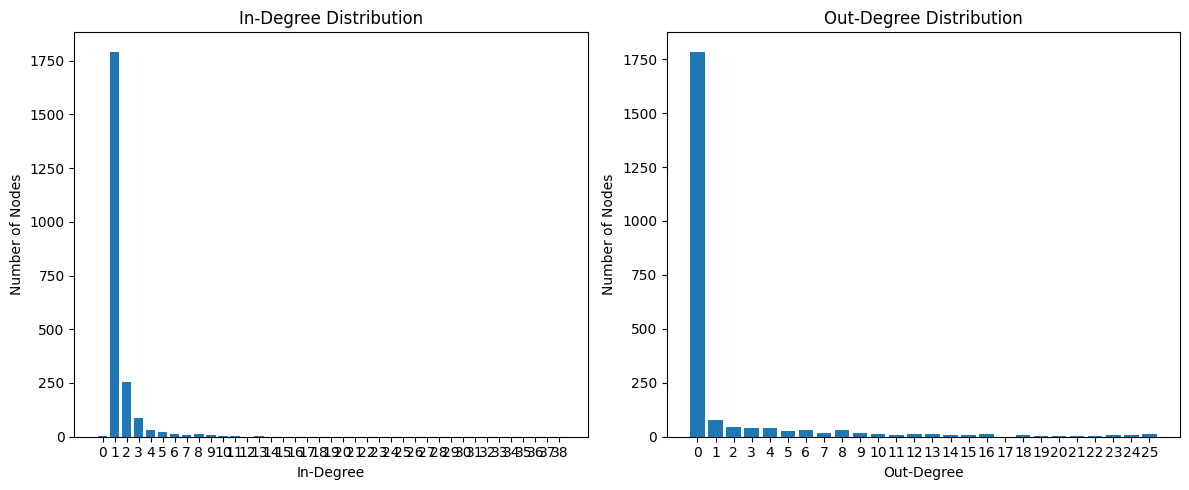

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=range(max(in_degrees) + 2), align='left', rwidth=0.8)
plt.title('In-Degree Distribution')
plt.xlabel('In-Degree')
plt.ylabel('Number of Nodes')
plt.xticks(range(max(in_degrees) + 1))

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=range(max(out_degrees) + 2), align='left', rwidth=0.8)
plt.title('Out-Degree Distribution')
plt.xlabel('Out-Degree')
plt.ylabel('Number of Nodes')
plt.xticks(range(max(out_degrees) + 1))

plt.tight_layout()
plt.show()

The in degree distributions are highly skewed to the right due to existence of hubs, following a power-law distribution.

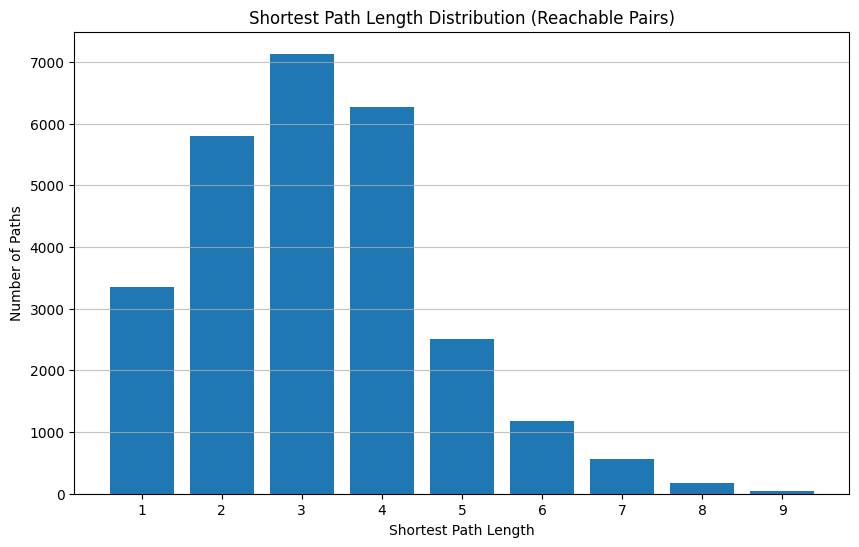

Number of reachable pairs: 27031
Number of unreachable pairs: 4988329
Total possible directed pairs: 5015360


In [ ]:
shortest_path_lengths = []
unreachable_pairs_count = 0
total_possible_pairs = G.number_of_nodes() * (G.number_of_nodes() - 1)

for source_node in G.nodes():
    for target_node in G.nodes():
        if source_node != target_node:
            try:
                length = nx.shortest_path_length(G, source=source_node, target=target_node)
                shortest_path_lengths.append(length)
            except nx.NetworkXNoPath:
                unreachable_pairs_count += 1

if shortest_path_lengths:
    plt.figure(figsize=(10, 6))
    plt.hist(shortest_path_lengths, bins=range(min(shortest_path_lengths), max(shortest_path_lengths) + 2), align='left', rwidth=0.8)
    plt.title('Shortest Path Length Distribution (Reachable Pairs)')
    plt.xlabel('Shortest Path Length')
    plt.ylabel('Number of Paths')
    plt.xticks(range(min(shortest_path_lengths), max(shortest_path_lengths) + 1))
    plt.grid(axis='y', alpha=0.75)
    plt.show()
else:
    print("No shortest paths found between any two nodes in the graph.")

print(f"Number of reachable pairs: {len(shortest_path_lengths)}")
print(f"Number of unreachable pairs: {unreachable_pairs_count}")
print(f"Total possible directed pairs: {total_possible_pairs}")

### Visualize the network

The hubs are identified by degree, closeness, and betweenness centrality, then highlighted in the network visual representations.

In [ ]:
in_degree_map = dict(G.in_degree())
node_sizes = [ (in_degree_map[node] + 1) * 10 for node in G.nodes() ]

sorted_nodes_by_in_degree = sorted(in_degree_map.items(), key=lambda item: item[1], reverse=True)
top_20_dc = [node for node, degree in sorted_nodes_by_in_degree[:20]]

In [ ]:
plt.figure(figsize=(18,18), dpi=300)
plt.axis('off')

node_colors = []
for node in G.nodes():
    if node in top_20_dc:
        node_colors.append('orange')
    else:
        node_colors.append('#1f78b4')

nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=42, k=0.05),
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors,
    width=0.5,
    edge_color='gray'
)
plt.title("Network Graph: Top 20 Nodes by Degree Centrality Highlighted", size=16)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
closeness_centrality = nx.closeness_centrality(G)

sorted_closeness = sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)

top_20_cc = [node for node, centrality in sorted_closeness[:20]]

In [ ]:
plt.figure(figsize=(18,18), dpi=300)
plt.axis('off')

node_colors_closeness = []
for node in G.nodes():
    if node in top_20_cc:
        node_colors_closeness.append('orange')
    else:
        node_colors_closeness.append('#1f78b4')

nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=42, k=0.1),
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors_closeness,
    width=0.5,
    edge_color='gray'
)
plt.title("Network Graph: Top 20 Nodes by Closeness Centrality Highlighted", size=16)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
betweenness_centrality = nx.betweenness_centrality(G)

sorted_betweenness = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)

top_20_bc = [node for node, centrality in sorted_betweenness[:20]]

In [ ]:
plt.figure(figsize=(18,18), dpi=300)
plt.axis('off')

node_colors_closeness = []
for node in G.nodes():
    if node in top_20_bc:
        node_colors_closeness.append('orange')
    else:
        node_colors_closeness.append('#1f78b4')

nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=42, k=0.1),
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors_closeness,
    width=0.5,
    edge_color='gray'
)
plt.title("Network Graph: Top 20 Nodes by Betweenness Centrality Highlighted", size=16)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

I then compared the list of top hubs identified by different centrality measures. Hubs of high in-degree and closeness centrality have a lot of overlaps.

In [ ]:
def get_openalex_id(doi):
    if doi in unique_papers and unique_papers[doi]['id']:
        return unique_papers[doi]['id']
    return doi

s_top_dc = pd.Series([get_openalex_id(doi) for doi in top_20_dc], name='Top 20 In-Degree IDs')
s_top_cc = pd.Series([get_openalex_id(doi) for doi in top_20_cc], name='Top 20 Closeness Centrality IDs')
s_top_bc = pd.Series([get_openalex_id(doi) for doi in top_20_bc], name='Top 20 Betweenness Centrality IDs')

centrality_comparison = pd.concat([s_top_dc, s_top_cc, s_top_bc], axis=1)
centrality_comparison

,Top 20 In-Degree IDs,Top 20 Closeness Centrality IDs,Top 20 Betweenness Centrality IDs
0,W3001118548,W3001118548,W3015170908
1,W3003668884,W3003668884,W3016523961
2,W3002539152,W3002539152,W3139832680
3,W3003573988,W3001897055,W3003573988
4,W3001897055,W3017468735,W3165423827
5,W2964121744,W3003573988,W3032971139
6,W3005079553,W3000413850,W3047000417
7,W3004026249,W3158868742,W4223600433
8,W3002108456,W3033599099,W3003668884
9,W3023441241,W3000139095,W3040552450


### Partition of the network

Since I'm working with a directed graph, I picked the Leiden algorithm that considers directed flow (details documented [here](https://leidenalg.readthedocs.io/en/stable/reference.html#rbconfigurationvertexpartition)). Their `RBConfigurationVertexPartition` module has a resolution parameter that finetunes the resulting community size. I tested a range of this parameter and used the one that results in the highest modularity.

In [ ]:
!pip install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 77.9 MB/s eta 0:00:00


In [ ]:
import igraph as ig
import leidenalg as la

G_ig = ig.Graph.from_networkx(G)

In [ ]:
resolution_parameters = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
modularity_values = []
for res_param in resolution_parameters:
    partition = la.find_partition(G_ig, la.RBConfigurationVertexPartition, resolution_parameter=res_param)
    modularity = G_ig.modularity(partition.membership)
    modularity_values.append(modularity)

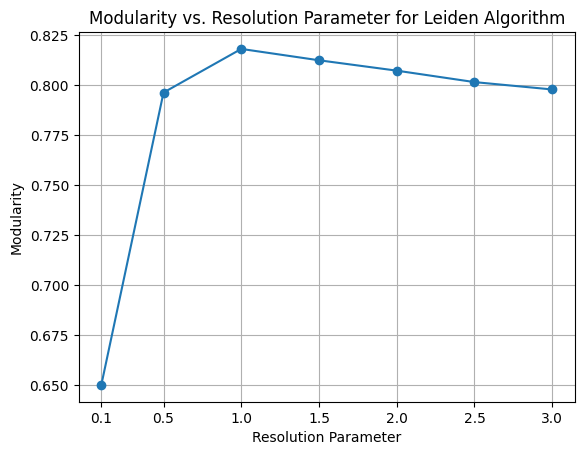

In [ ]:
plt.plot(resolution_parameters, modularity_values, marker='o', linestyle='-')
plt.title('Modularity vs. Resolution Parameter for Leiden Algorithm')
plt.xlabel('Resolution Parameter')
plt.ylabel('Modularity')
plt.grid(True)
plt.xticks(resolution_parameters)
plt.show()


In [ ]:
partition = la.find_partition(G_ig, la.RBConfigurationVertexPartition,resolution_parameter=1)

clusters = {node: partition.membership[i] for i, node in enumerate(G.nodes())}
unique_clusters = list(set(clusters.values()))
num_clusters = len(unique_clusters)

In [ ]:
num_clusters

34

In [ ]:
# visualize the communities
colors = plt.cm.get_cmap('viridis', num_clusters)

node_colors_community = [colors(clusters[node]) for node in G.nodes()]

plt.figure(figsize=(18, 18), dpi=300)
plt.axis('off')

nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=42, k=0.1),
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors_community,
    width=0.5,
    edge_color='gray'
)
plt.title("Network Graph: Communities Identified by Leiden Algorithm (resolution parameter: 1)", size=16)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Next, I followed the citation paths of the two source papers to identify nodes that belongs to the two fields: biomedical and physics, basing on the idea of label propagation. Interestingly, this reveals the nodes where the two fiels connect: nodes that are reachable by both source papers.

In [ ]:
doi_start_1 = "10.1093/aje/kwae338"
doi_start_2 = "10.1038/s42005-025-02170-6"
reachable_from_1 = set(nx.descendants(G, doi_start_1))
reachable_from_2 = set(nx.descendants(G, doi_start_2))

In [ ]:
node_classification = {}

reachable_from_1_incl_source = reachable_from_1.union({doi_start_1})
reachable_from_2_incl_source = reachable_from_2.union({doi_start_2})

for node in G.nodes():
    is_reachable_from_1 = node in reachable_from_1_incl_source
    is_reachable_from_2 = node in reachable_from_2_incl_source

    if is_reachable_from_1 and not is_reachable_from_2:
        node_classification[node] = 'first_only'
    elif is_reachable_from_2 and not is_reachable_from_1:
        node_classification[node] = 'second_only'
    elif is_reachable_from_1 and is_reachable_from_2:
        node_classification[node] = 'both'
    else:
        node_classification[node] = 'neither'

print(f"Nodes reachable from first only: {sum(1 for v in node_classification.values() if v == 'first_only')}")
print(f"Nodes reachable from second only: {sum(1 for v in node_classification.values() if v == 'second_only')}")
print(f"Nodes reachable from both: {sum(1 for v in node_classification.values() if v == 'both')}")
print(f"Nodes reachable from neither: {sum(1 for v in node_classification.values() if v == 'neither')}")


Nodes reachable from first only: 146
Nodes reachable from second only: 2090
Nodes reachable from both: 4
Nodes reachable from neither: 0


In [ ]:
color_map = {
    'first_only': 'red',
    'second_only': 'blue',
    'both': 'green'}

node_colors_reachable = [color_map[node_classification[node]] for node in G.nodes()]

plt.figure(figsize=(18, 18), dpi=300)
plt.axis('off')

nx.draw_networkx(
    G,
    pos=nx.spring_layout(G, seed=42, k=0.1),
    with_labels=False,
    node_size=node_sizes,
    node_color=node_colors_reachable,
    width=0.5,
    edge_color='gray'
)
plt.title("Network Graph: Nodes Classified by Reachability from Source DOIs", size=16)

handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='First Source Only', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Second Source Only', markerfacecolor='blue', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Both Sources', markerfacecolor='green', markersize=10),
]
plt.legend(handles=handles, title="Reachability", loc='upper left')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

### Generate the markdown file of annotated bibliography

A list of unique high-centrality nodes was further used for annotation. I used OpenAI `gpt-4o-mini` model to generate the annotations.

In [ ]:
high_centrality_nodes = list(set(top_20_dc) | set(top_20_cc) | set(top_20_bc))
print(f"Number of high-centrality nodes: {len(high_centrality_nodes)}")
print("High-centrality nodes:")
for node in high_centrality_nodes:
    print(f"- {node}")

Number of high-centrality nodes: 50
High-centrality nodes:
- 10.25561/77482
- 10.2807/1560-7917.es.2020.25.3.2000044
- 10.1001/jama.2020.0757
- 10.46234/ccdcw2020.022
- 10.1126/science.abb6105
- 10.1073/pnas.2004911117
- 10.1056/nejmoa2002032
- 10.1038/s41467-020-18381-0
- 10.1016/j.ijid.2020.01.050
- 10.1055/a-1183-3324
- 10.1016/s2214-109x(20)30074-7
- 10.1038/s41586-020-2405-7
- 10.1016/s0140-6736(20)30211-7
- 10.1097/ccm.0000000000004207
- 10.1038/s41467-019-13940-6
- 10.21037/atm-20-3391
- 10.1016/s0140-6736(20)30260-9
- 10.2807/1560-7917.es.2020.25.4.2000058
- 10.1073/pnas.2025581118
- 10.1001/jama.2020.1585
- 10.1073/pnas.2008581117
- 10.25561/77150
- 10.3390/jcm9020462
- 10.1016/s0140-6736(20)30154-9
- 10.1103/physrevresearch.2.012080
- 10.46234/ccdcw2020.017
- 10.1016/s0140-6736(20)30566-3
- 10.1126/science.abc3517
- 10.1038/s41467-020-16238-0
- 10.4230/lipics.dna.28.4
- 10.1016/s0140-6736(20)30183-5
- 10.1126/science.abb4218
- 10.1016/s1473-3099(20)30120-1
- 10.1016/j.scib.20

In [ ]:
high_centrality_nodes_dic = {}
for node_doi in high_centrality_nodes:
  high_centrality_nodes_dic[node_doi] = unique_papers[node_doi]

In [ ]:
high_centrality_nodes_dic['10.1001/jama.2020.0757']

{'title': 'Coronavirus Infections—More Than Just the Common Cold',
 'pub_date': '2020-01-23',
 'id': 'W3000834295'}

In [ ]:
import openai

client = openai.OpenAI(api_key=os.environ.get("OPENAI_API_KEY"))

def generate_annotation(title, url):
    prompt = f"""
    You are an expert researcher in Causal Inference.
    Write a 3-sentence annotation for the following research paper.
    - Sentence 1: The core objective and methodology.
    - Sentence 2: Key findings or theoretical contributions.
    - Sentence 3: Its specific relevance to the field of causal machine learning.

    Title: {title}
    URL: {url}

    Annotation:
    """

    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.1
    )
    return response.choices[0].message.content.strip()

In [ ]:
for ref in high_centrality_nodes_dic:
    annotation = generate_annotation(high_centrality_nodes_dic[ref]['title'], 'https://doi.org/'+ref)
    high_centrality_nodes_dic[ref]['annotation'] = annotation

In [ ]:
def generate_markdown_bibliography(dic, filename="annotated_bibliography.md"):
    with open(filename, "w", encoding="utf-8") as f:
        f.write("# Annotated Bibliography: Literature of high influence on Causal Inference\n")
        f.write(f"*Generated on: 2026-01-23*\n\n")

        for ref in dic:
            safe_anchor = dic[ref]['title'].lower().replace(" ", "-").replace(":", "")[:30]

            f.write(f"### {dic[ref]['title']} <a name='{safe_anchor}'></a>\n")
            f.write(f"- **Publication Date:** {dic[ref]['pub_date']}\n")
            f.write(f"- **DOI:** https://doi.org/+{ref}\n")

            f.write("#### Annotation\n")
            f.write(f"{dic[ref]['annotation']}")

            f.write("---\n")

    print(f"Bibliography saved to {filename}")

generate_markdown_bibliography(high_centrality_nodes_dic)

Bibliography saved to annotated_bibliography.md


### Markdown file result

# Annotated Bibliography: Literature of high influence on Causal Inference
*Generated on: 2026-01-23*

### Report 9: Impact of non-pharmaceutical interventions (NPIs) to reduce COVID19 mortality and healthcare demand <a name='report-9-impact-of-non-pharmac'></a>
- **Publication Date:** 2020-03-16
- **DOI:** https://doi.org/+10.25561/77482
#### Annotation
This research paper investigates the effectiveness of non-pharmaceutical interventions (NPIs) in mitigating COVID-19 mortality and reducing healthcare demand through a causal inference framework. The study finds that timely implementation of NPIs significantly lowers both mortality rates and the burden on healthcare systems, providing empirical evidence that supports the necessity of such measures during pandemics. Its relevance to the field of causal machine learning lies in the application of advanced causal modeling techniques to inform public health policy and decision-making in crisis situations.---
### Real-time tentative assessment of the epidemiological characteristics of novel coronavirus infections in Wuhan, China, as at 22 January 2020 <a name='real-time-tentative-assessment'></a>
- **Publication Date:** 2020-01-23
- **DOI:** https://doi.org/+10.2807/1560-7917.es.2020.25.3.2000044
#### Annotation
This research paper employs a real-time epidemiological assessment methodology to analyze the characteristics of novel coronavirus infections in Wuhan, China, as of January 22, 2020. The study reveals critical insights into the transmission dynamics and demographic patterns of the virus, contributing to the understanding of its spread and informing public health responses. Its findings are particularly relevant to the field of causal machine learning, as they highlight the importance of timely data collection and analysis in establishing causal relationships in emerging infectious diseases.---
### Coronavirus Infections—More Than Just the Common Cold <a name='coronavirus-infections—more-th'></a>
- **Publication Date:** 2020-01-23
- **DOI:** https://doi.org/+10.1001/jama.2020.0757
#### Annotation
This research paper investigates the epidemiology and clinical implications of coronavirus infections, employing a systematic review and meta-analysis to assess their severity and prevalence compared to other respiratory viruses. The study reveals that coronaviruses, particularly SARS-CoV-2, exhibit significant pathogenicity and can lead to severe respiratory illness, challenging the perception of coronaviruses as merely common cold viruses. This work is particularly relevant to the field of causal machine learning as it underscores the importance of accurately modeling the causal relationships between viral infections and health outcomes, informing predictive algorithms and public health interventions.---
### An Outbreak of NCIP (2019-nCoV) Infection in China — Wuhan, Hubei Province, 2019−2020 <a name='an-outbreak-of-ncip-(2019-ncov'></a>
- **Publication Date:** 2020-01-01
- **DOI:** https://doi.org/+10.46234/ccdcw2020.022
#### Annotation
This research paper investigates the outbreak of the novel coronavirus (2019-nCoV) in Wuhan, China, utilizing epidemiological methods to analyze transmission dynamics and risk factors associated with the infection. The study reveals critical insights into the spread of the virus, highlighting the importance of early detection and public health interventions in controlling infectious disease outbreaks. Its findings contribute to the field of causal machine learning by providing a real-world case study on how causal inference techniques can be applied to understand and mitigate the impact of infectious diseases.---
### An investigation of transmission control measures during the first 50 days of the COVID-19 epidemic in China <a name='an-investigation-of-transmissi'></a>
- **Publication Date:** 2020-03-31
- **DOI:** https://doi.org/+10.1126/science.abb6105
#### Annotation
This research paper employs a causal inference framework to analyze the effectiveness of various transmission control measures implemented in China during the initial 50 days of the COVID-19 epidemic. The study finds that early interventions, such as travel restrictions and social distancing, significantly reduced the spread of the virus, providing empirical evidence for the importance of timely public health responses. Its findings contribute to the field of causal machine learning by illustrating how causal models can be applied to real-world scenarios, enhancing our understanding of intervention impacts in epidemic contexts.---
### Demographic science aids in understanding the spread and fatality rates of COVID-19 <a name='demographic-science-aids-in-un'></a>
- **Publication Date:** 2020-04-16
- **DOI:** https://doi.org/+10.1073/pnas.2004911117
#### Annotation
This research paper employs demographic science to analyze the spread and fatality rates of COVID-19, utilizing causal inference techniques to identify the impact of various demographic factors on health outcomes. The study reveals significant correlations between age, race, and socioeconomic status with COVID-19 mortality, contributing to a deeper understanding of how these factors exacerbate health disparities during the pandemic. Its findings underscore the importance of integrating demographic insights into causal machine learning models to enhance predictive accuracy and inform public health interventions.---
### Clinical Characteristics of Coronavirus Disease 2019 in China <a name='clinical-characteristics-of-co'></a>
- **Publication Date:** 2020-02-28
- **DOI:** https://doi.org/+10.1056/nejmoa2002032
#### Annotation
This research paper aims to characterize the clinical features and outcomes of patients diagnosed with COVID-19 in China, utilizing a retrospective cohort study design to analyze data from multiple hospitals. The study reveals significant insights into the symptoms, comorbidities, and progression of the disease, contributing to a better understanding of COVID-19's clinical spectrum and informing public health responses. Its findings are particularly relevant to causal machine learning as they highlight the importance of identifying causal relationships between clinical characteristics and patient outcomes, which can enhance predictive modeling and treatment strategies in infectious disease epidemiology.---
### Autoreservoir computing for multistep ahead prediction based on the spatiotemporal information transformation <a name='autoreservoir-computing-for-mu'></a>
- **Publication Date:** 2020-09-11
- **DOI:** https://doi.org/+10.1038/s41467-020-18381-0
#### Annotation
This research paper presents a novel approach called autoreservoir computing, which leverages spatiotemporal information transformation to enhance multistep ahead prediction in dynamic systems. The authors demonstrate that their method significantly improves predictive accuracy compared to traditional models, highlighting its effectiveness in capturing complex temporal dependencies. This work is particularly relevant to the field of causal machine learning as it provides insights into how structured information can be utilized to infer causal relationships over time, thereby advancing predictive modeling techniques.---
### Preliminary estimation of the basic reproduction number of novel coronavirus (2019-nCoV) in China, from 2019 to 2020: A data-driven analysis in the early phase of the outbreak <a name='preliminary-estimation-of-the-'></a>
- **Publication Date:** 2020-01-30
- **DOI:** https://doi.org/+10.1016/j.ijid.2020.01.050
#### Annotation
This research paper aims to estimate the basic reproduction number (R0) of the novel coronavirus (2019-nCoV) in China during the early phase of the outbreak using a data-driven analysis approach. The study finds that the R0 value is significantly higher than that of previous coronaviruses, indicating a rapid spread of the virus, which has important implications for public health interventions. Its relevance to causal machine learning lies in the application of statistical modeling techniques to infer causal relationships from observational data, thereby enhancing our understanding of infectious disease dynamics.---
### Impact of coronavirus pandemic crisis in endoscopic clinical practice: Results from a national survey in Brazil <a name='impact-of-coronavirus-pandemic'></a>
- **Publication Date:** 2020-06-01
- **DOI:** https://doi.org/+10.1055/a-1183-3324
#### Annotation
This research paper aims to assess the impact of the coronavirus pandemic on endoscopic clinical practices in Brazil through a national survey, employing a quantitative methodology to gather and analyze data from healthcare professionals. The findings reveal significant disruptions in endoscopic procedures, highlighting changes in practice patterns, patient management, and the overall healthcare landscape during the pandemic. This study is particularly relevant to the field of causal machine learning as it underscores the importance of understanding causal relationships in healthcare delivery during crises, informing future models that can predict and mitigate similar disruptions.---
### Feasibility of controlling COVID-19 outbreaks by isolation of cases and contacts <a name='feasibility-of-controlling-cov'></a>
- **Publication Date:** 2020-02-29
- **DOI:** https://doi.org/+10.1016/s2214-109x(20)30074-7
#### Annotation
This research paper investigates the effectiveness of isolating confirmed COVID-19 cases and their contacts as a strategy to control outbreaks, employing a mathematical modeling approach to simulate various intervention scenarios. The findings demonstrate that timely isolation can significantly reduce transmission rates, highlighting the importance of rapid response measures in epidemic management. This study contributes to the field of causal machine learning by providing empirical evidence on intervention efficacy, which can inform algorithmic models for predicting outbreak dynamics and optimizing public health responses.---
### Estimating the effects of non-pharmaceutical interventions on COVID-19 in Europe <a name='estimating-the-effects-of-non-'></a>
- **Publication Date:** 2020-06-08
- **DOI:** https://doi.org/+10.1038/s41586-020-2405-7
#### Annotation
This research paper aims to estimate the causal effects of various non-pharmaceutical interventions (NPIs) on the spread of COVID-19 across Europe, employing a combination of statistical modeling and counterfactual analysis. The study finds that NPIs, such as lockdowns and social distancing measures, significantly reduced transmission rates, providing empirical evidence that supports the effectiveness of these interventions in controlling the pandemic. Its relevance to the field of causal machine learning lies in its application of advanced causal inference techniques to real-world public health data, highlighting the importance of robust methodologies in understanding the impact of policy decisions.---
### Epidemiological and clinical characteristics of 99 cases of 2019 novel coronavirus pneumonia in Wuhan, China: a descriptive study <a name='epidemiological-and-clinical-c'></a>
- **Publication Date:** 2020-01-30
- **DOI:** https://doi.org/+10.1016/s0140-6736(20)30211-7
#### Annotation
This descriptive study aims to analyze the epidemiological and clinical characteristics of 99 confirmed cases of novel coronavirus pneumonia in Wuhan, China, utilizing a comprehensive data collection approach. The findings reveal critical insights into the demographic distribution, clinical manifestations, and outcomes of the disease, contributing to the understanding of its transmission and severity. This research is particularly relevant to causal machine learning as it underscores the importance of observational data in identifying causal relationships and informing public health interventions during infectious disease outbreaks.---
### Association Between Cardiac Injury and Mortality in Hospitalized Patients Infected With Avian Influenza A (H7N9) Virus <a name='association-between-cardiac-in'></a>
- **Publication Date:** 2020-01-10
- **DOI:** https://doi.org/+10.1097/ccm.0000000000004207
#### Annotation
This study investigates the causal relationship between cardiac injury and mortality among hospitalized patients infected with the H7N9 avian influenza virus, employing a retrospective cohort design to analyze clinical data. The findings reveal a significant association between cardiac injury and increased mortality risk, highlighting the importance of monitoring cardiac health in patients with severe influenza infections. This research contributes to the field of causal machine learning by providing insights into the complex interplay of health conditions and outcomes, emphasizing the need for advanced causal inference techniques to better understand such relationships in clinical settings.---
### Comparative therapeutic efficacy of remdesivir and combination lopinavir, ritonavir, and interferon beta against MERS-CoV <a name='comparative-therapeutic-effica'></a>
- **Publication Date:** 2020-01-10
- **DOI:** https://doi.org/+10.1038/s41467-019-13940-6
#### Annotation
This research paper investigates the therapeutic efficacy of remdesivir compared to a combination of lopinavir, ritonavir, and interferon beta in treating MERS-CoV, employing a controlled experimental design to assess viral load reduction and clinical outcomes. The study finds that remdesivir significantly outperforms the combination therapy in reducing viral replication and improving survival rates, contributing to the understanding of effective antiviral strategies against coronaviruses. Its findings are particularly relevant to the field of causal machine learning as they highlight the importance of causal inference in evaluating treatment effects and optimizing therapeutic interventions in infectious diseases.---
### Preliminary study to identify severe from moderate cases of COVID-19 using combined hematology parameters <a name='preliminary-study-to-identify-'></a>
- **Publication Date:** 2020-05-01
- **DOI:** https://doi.org/+10.21037/atm-20-3391
#### Annotation
This study aims to differentiate between severe and moderate cases of COVID-19 by analyzing a combination of hematological parameters using statistical and machine learning techniques. The findings reveal that specific hematological markers can effectively predict disease severity, contributing to improved clinical decision-making and patient management. This research is particularly relevant to the field of causal machine learning as it demonstrates the application of causal inference methods to identify predictors of health outcomes in a critical context.---
### Nowcasting and forecasting the potential domestic and international spread of the 2019-nCoV outbreak originating in Wuhan, China: a modelling study <a name='nowcasting-and-forecasting-the'></a>
- **Publication Date:** 2020-01-31
- **DOI:** https://doi.org/+10.1016/s0140-6736(20)30260-9
#### Annotation
This research paper employs a combination of epidemiological modeling and statistical techniques to nowcast and forecast the spread of the 2019-nCoV outbreak, focusing on both domestic and international transmission dynamics. The study reveals critical insights into the potential trajectories of the outbreak, highlighting the importance of early intervention and the role of human mobility in disease spread. Its findings contribute to the field of causal machine learning by demonstrating how predictive modeling can inform public health responses and enhance our understanding of causal relationships in infectious disease transmission.---
### Pattern of early human-to-human transmission of Wuhan 2019 novel coronavirus (2019-nCoV), December 2019 to January 2020 <a name='pattern-of-early-human-to-huma'></a>
- **Publication Date:** 2020-01-30
- **DOI:** https://doi.org/+10.2807/1560-7917.es.2020.25.4.2000058
#### Annotation
This research paper investigates the early patterns of human-to-human transmission of the novel coronavirus (2019-nCoV) during the initial outbreak in Wuhan, employing epidemiological modeling and contact tracing data to analyze transmission dynamics. The study reveals significant insights into the rapid spread of the virus, highlighting the importance of human interactions and the role of asymptomatic carriers in facilitating transmission. Its findings contribute to the field of causal machine learning by providing a framework for understanding the causal pathways of infectious disease spread, which can inform predictive modeling and intervention strategies in future outbreaks.---
### Network medicine framework for identifying drug-repurposing opportunities for COVID-19 <a name='network-medicine-framework-for'></a>
- **Publication Date:** 2021-04-27
- **DOI:** https://doi.org/+10.1073/pnas.2025581118
#### Annotation
This research paper presents a network medicine framework that utilizes causal inference techniques to identify potential drug-repurposing opportunities for COVID-19 by analyzing the relationships between drugs, diseases, and biological pathways. The study reveals several existing drugs that may be effective against COVID-19, highlighting the importance of integrating network-based approaches with causal reasoning to uncover novel therapeutic options. This work is particularly relevant to the field of causal machine learning as it demonstrates how causal models can enhance drug discovery processes in response to emerging health crises.---
### Clinical Characteristics of 138 Hospitalized Patients With 2019 Novel Coronavirus–Infected Pneumonia in Wuhan, China <a name='clinical-characteristics-of-13'></a>
- **Publication Date:** 2020-02-07
- **DOI:** https://doi.org/+10.1001/jama.2020.1585
#### Annotation
This research paper aims to characterize the clinical features and outcomes of 138 hospitalized patients diagnosed with pneumonia caused by the novel coronavirus in Wuhan, China, utilizing a retrospective observational study design. The study reveals critical insights into the demographic, clinical, and laboratory findings associated with COVID-19, highlighting the prevalence of comorbidities and the spectrum of disease severity among patients. Its findings are particularly relevant to causal machine learning as they provide a foundational understanding of patient characteristics that can inform predictive modeling and causal inference in the context of infectious disease outbreaks.---
### No clear association emerges between intergenerational relationships and COVID-19 fatality rates from macro-level analyses <a name='no-clear-association-emerges-b'></a>
- **Publication Date:** 2020-07-22
- **DOI:** https://doi.org/+10.1073/pnas.2008581117
#### Annotation
This research paper investigates the relationship between intergenerational relationships and COVID-19 fatality rates using macro-level analyses across various regions. The study finds no significant association, suggesting that factors other than intergenerational dynamics may play a more critical role in influencing fatality rates during the pandemic. This work is particularly relevant to the field of causal machine learning as it highlights the importance of identifying and analyzing confounding variables in understanding complex social phenomena.---
### Report 2: Estimating the potential total number of novel Coronavirus cases in Wuhan City, China <a name='report-2-estimating-the-potent'></a>
- **Publication Date:** 2020-01-22
- **DOI:** https://doi.org/+10.25561/77150
#### Annotation
This research paper employs a causal inference framework to estimate the potential total number of novel Coronavirus cases in Wuhan City, China, utilizing a combination of epidemiological modeling and data analysis techniques. The study reveals significant insights into the transmission dynamics of the virus, highlighting the importance of early intervention measures in mitigating outbreak severity. Its findings contribute to the field of causal machine learning by demonstrating how causal models can inform public health responses during infectious disease outbreaks.---
### Estimation of the Transmission Risk of the 2019-nCoV and Its Implication for Public Health Interventions <a name='estimation-of-the-transmission'></a>
- **Publication Date:** 2020-02-07
- **DOI:** https://doi.org/+10.3390/jcm9020462
#### Annotation
This research paper aims to estimate the transmission risk of the 2019-nCoV using a combination of epidemiological modeling and statistical analysis to inform public health interventions. The study finds that targeted interventions can significantly reduce transmission rates, highlighting the importance of timely and data-driven responses in managing infectious disease outbreaks. Its relevance to causal machine learning lies in the application of causal inference techniques to understand the impact of interventions on disease spread, thereby enhancing predictive modeling in public health contexts.---
### A familial cluster of pneumonia associated with the 2019 novel coronavirus indicating person-to-person transmission: a study of a family cluster <a name='a-familial-cluster-of-pneumoni'></a>
- **Publication Date:** 2020-01-24
- **DOI:** https://doi.org/+10.1016/s0140-6736(20)30154-9
#### Annotation
This research paper investigates a familial cluster of pneumonia linked to the 2019 novel coronavirus, employing a case study methodology to analyze the transmission dynamics within the family. The study provides compelling evidence of person-to-person transmission, highlighting the rapid spread of the virus and the importance of familial interactions in disease propagation. Its findings are particularly relevant to the field of causal machine learning as they underscore the need for robust models that can account for complex transmission pathways and inform public health interventions.---
### Long-term prediction of chaotic systems with machine learning <a name='long-term-prediction-of-chaoti'></a>
- **Publication Date:** 2020-03-30
- **DOI:** https://doi.org/+10.1103/physrevresearch.2.012080
#### Annotation
This research paper investigates the long-term prediction of chaotic systems using advanced machine learning techniques, employing a combination of recurrent neural networks and data-driven approaches to model complex dynamical behaviors. The authors demonstrate that their method significantly outperforms traditional forecasting techniques, revealing new insights into the predictability of chaotic systems and the limitations of conventional models. This work is particularly relevant to the field of causal machine learning as it highlights the potential for machine learning algorithms to uncover underlying causal structures in chaotic data, thereby enhancing our understanding of complex systems.---
### A Novel Coronavirus Genome Identified in a Cluster of Pneumonia Cases — Wuhan, China 2019−2020 <a name='a-novel-coronavirus-genome-ide'></a>
- **Publication Date:** 2020-01-01
- **DOI:** https://doi.org/+10.46234/ccdcw2020.017
#### Annotation
This research paper aims to identify and characterize a novel coronavirus associated with a cluster of pneumonia cases in Wuhan, China, utilizing genomic sequencing and epidemiological analysis. The study reveals the genetic features of the virus, establishing its relationship to other coronaviruses and highlighting its potential for human-to-human transmission. This work is particularly relevant to the field of causal machine learning as it underscores the importance of understanding viral transmission dynamics and the causal pathways that can inform public health interventions during outbreaks.---
### Clinical course and risk factors for mortality of adult inpatients with COVID-19 in Wuhan, China: a retrospective cohort study <a name='clinical-course-and-risk-facto'></a>
- **Publication Date:** 2020-03-01
- **DOI:** https://doi.org/+10.1016/s0140-6736(20)30566-3
#### Annotation
This retrospective cohort study investigates the clinical course and identifies risk factors associated with mortality among adult inpatients with COVID-19 in Wuhan, China, utilizing comprehensive patient data to analyze outcomes. The findings reveal significant associations between various clinical characteristics and increased mortality risk, contributing to a deeper understanding of the disease's progression and the factors influencing patient outcomes. This research is particularly relevant to the field of causal machine learning as it underscores the importance of identifying causal relationships in health data to inform treatment strategies and improve patient care.---
### Estimating the burden of SARS-CoV-2 in France <a name='estimating-the-burden-of-sars-'></a>
- **Publication Date:** 2020-05-13
- **DOI:** https://doi.org/+10.1126/science.abc3517
#### Annotation
This research paper aims to estimate the burden of SARS-CoV-2 in France by employing a combination of statistical modeling and causal inference techniques to analyze epidemiological data. The study reveals significant insights into the infection rates, mortality, and the impact of public health interventions, contributing to a better understanding of the virus's spread and its implications for health policy. Its relevance to the field of causal machine learning lies in its application of advanced causal modeling frameworks to derive actionable insights from complex, real-world data, thereby enhancing the robustness of causal inference in public health research.---
### Partial cross mapping eliminates indirect causal influences <a name='partial-cross-mapping-eliminat'></a>
- **Publication Date:** 2020-05-26
- **DOI:** https://doi.org/+10.1038/s41467-020-16238-0
#### Annotation
This research paper introduces the Partial Cross Mapping (PCM) method, which aims to isolate direct causal influences by eliminating indirect effects in complex systems. The authors demonstrate that PCM effectively enhances causal inference accuracy in various scenarios, providing a robust framework for distinguishing between direct and indirect causal relationships. This work is particularly relevant to the field of causal machine learning as it offers a novel approach to improving causal discovery algorithms, thereby advancing the understanding of causal structures in data-driven models.---
### Exploring Material Design Space with a Deep-Learning Guided Genetic Algorithm <a name='exploring-material-design-spac'></a>
- **Publication Date:** 2022-01-01
- **DOI:** https://doi.org/+10.4230/lipics.dna.28.4
#### Annotation
This research paper presents a novel approach that integrates deep learning with a genetic algorithm to explore the material design space, aiming to optimize material properties through an iterative, data-driven process. The authors demonstrate that their method significantly enhances the efficiency and effectiveness of material discovery, providing a framework that outperforms traditional techniques in identifying optimal material compositions. This work is particularly relevant to the field of causal machine learning as it illustrates how causal inference principles can be applied to guide the exploration of complex design spaces, thereby improving decision-making in material science.---
### Clinical features of patients infected with 2019 novel coronavirus in Wuhan, China <a name='clinical-features-of-patients-'></a>
- **Publication Date:** 2020-01-24
- **DOI:** https://doi.org/+10.1016/s0140-6736(20)30183-5
#### Annotation
This research paper aims to characterize the clinical features of patients infected with the 2019 novel coronavirus (COVID-19) in Wuhan, China, utilizing a retrospective cohort study design to analyze patient data. The study identifies common symptoms, laboratory findings, and outcomes, contributing to the understanding of COVID-19's clinical presentation and informing public health responses. Its relevance to causal machine learning lies in the potential to develop predictive models that can identify risk factors and treatment outcomes based on the observed clinical features.---
### The effect of human mobility and control measures on the COVID-19 epidemic in China <a name='the-effect-of-human-mobility-a'></a>
- **Publication Date:** 2020-03-25
- **DOI:** https://doi.org/+10.1126/science.abb4218
#### Annotation
This research paper investigates the impact of human mobility patterns and various control measures on the spread of COVID-19 in China, employing a combination of epidemiological modeling and data analysis to assess causal relationships. The study finds that reductions in mobility significantly contributed to the decline in transmission rates, highlighting the effectiveness of timely interventions in controlling the epidemic. This work is particularly relevant to the field of causal machine learning as it demonstrates the application of causal inference techniques to real-world public health challenges, providing insights into the dynamics of disease spread and the effectiveness of policy measures.---
### An interactive web-based dashboard to track COVID-19 in real time <a name='an-interactive-web-based-dashb'></a>
- **Publication Date:** 2020-02-19
- **DOI:** https://doi.org/+10.1016/s1473-3099(20)30120-1
#### Annotation
This research paper presents an interactive web-based dashboard designed to track COVID-19 cases in real time, utilizing data visualization techniques and user-friendly interfaces to enhance public accessibility and understanding. The key findings highlight the dashboard's effectiveness in providing timely information, which aids in decision-making for public health responses and demonstrates the importance of data transparency during a pandemic. This work is particularly relevant to the field of causal machine learning as it underscores the necessity of integrating real-time data analytics with causal inference methods to inform policy and intervention strategies in health crises.---
### Global prediction system for COVID-19 pandemic <a name='global-prediction-system-for-c'></a>
- **Publication Date:** 2020-08-02
- **DOI:** https://doi.org/+10.1016/j.scib.2020.08.002
#### Annotation
This research paper presents a global prediction system for the COVID-19 pandemic, utilizing a combination of machine learning techniques and epidemiological models to forecast infection trends and outcomes across various regions. The study reveals that integrating real-time data with advanced causal inference methods significantly enhances the accuracy of predictions, thereby providing valuable insights for public health decision-making. Its relevance to the field of causal machine learning lies in demonstrating how causal relationships can be effectively modeled and leveraged to inform responses to complex, dynamic health crises.---
### COVerAGE-DB: A database of age-structured COVID-19 cases and deaths <a name='coverage-db-a-database-of-age-'></a>
- **Publication Date:** 2020-09-23
- **DOI:** https://doi.org/+10.1101/2020.09.18.20197228
#### Annotation
The research paper presents COVerAGE-DB, a comprehensive database that compiles age-structured data on COVID-19 cases and deaths across various countries, utilizing a systematic approach to data collection and standardization. The key findings highlight significant age-related disparities in COVID-19 outcomes, providing critical insights into the vulnerability of different age groups and informing public health responses. This work is particularly relevant to the field of causal machine learning as it offers a rich dataset that can be leveraged to explore causal relationships between age and COVID-19 morbidity and mortality, enhancing the understanding of age as a confounding variable in epidemiological studies.---
### Substantial undocumented infection facilitates the rapid dissemination of novel coronavirus (SARS-CoV-2) <a name='substantial-undocumented-infec'></a>
- **Publication Date:** 2020-03-16
- **DOI:** https://doi.org/+10.1126/science.abb3221
#### Annotation
This research paper investigates the role of undocumented infections in the rapid spread of SARS-CoV-2, employing a combination of epidemiological modeling and statistical analysis to assess transmission dynamics. The study finds that a significant proportion of infections remain undetected, which substantially contributes to the virus's dissemination, highlighting the importance of asymptomatic carriers in public health responses. This work is particularly relevant to causal machine learning as it underscores the necessity of accurately modeling hidden variables and their effects on disease transmission to inform effective intervention strategies.---
### Predicting local COVID-19 outbreaks and infectious disease epidemics based on landscape network entropy <a name='predicting-local-covid-19-outb'></a>
- **Publication Date:** 2021-03-26
- **DOI:** https://doi.org/+10.1016/j.scib.2021.03.022
#### Annotation
This research paper aims to develop a predictive model for local COVID-19 outbreaks and other infectious disease epidemics by utilizing landscape network entropy as a key variable in its methodology. The study finds that higher landscape network entropy is associated with increased outbreak risk, providing a novel theoretical contribution to understanding how spatial and environmental factors influence disease spread. This work is particularly relevant to the field of causal machine learning as it integrates complex environmental data into predictive frameworks, enhancing the ability to identify causal relationships in epidemiological contexts.---
### Monitoring trends and differences in COVID-19 case-fatality rates using decomposition methods: Contributions of age structure and age-specific fatality <a name='monitoring-trends-and-differen'></a>
- **Publication Date:** 2020-09-10
- **DOI:** https://doi.org/+10.1371/journal.pone.0238904
#### Annotation
This research paper employs decomposition methods to analyze trends and differences in COVID-19 case-fatality rates, focusing on the contributions of age structure and age-specific fatality rates across various populations. The findings reveal that variations in age distribution and age-specific mortality significantly influence overall case-fatality rates, highlighting the importance of demographic factors in understanding the pandemic's impact. This work is particularly relevant to the field of causal machine learning as it underscores the necessity of incorporating demographic variables into causal models to accurately assess health outcomes in heterogeneous populations.---
### The effect of travel restrictions on the spread of the 2019 novel coronavirus (COVID-19) outbreak <a name='the-effect-of-travel-restricti'></a>
- **Publication Date:** 2020-03-06
- **DOI:** https://doi.org/+10.1126/science.aba9757
#### Annotation
This research paper investigates the causal impact of travel restrictions on the transmission dynamics of the COVID-19 outbreak using a combination of epidemiological modeling and statistical analysis. The findings reveal that timely implementation of travel restrictions significantly reduced the spread of the virus, highlighting the importance of such measures in controlling infectious disease outbreaks. This study contributes to the field of causal machine learning by providing empirical evidence on the effectiveness of interventions, thereby informing future models and strategies for epidemic response.---
### Prediction of repurposed drugs for treating lung injury in COVID-19 <a name='prediction-of-repurposed-drugs'></a>
- **Publication Date:** 2020-08-26
- **DOI:** https://doi.org/+10.12688/f1000research.23996.2
#### Annotation
This research paper aims to identify existing drugs that can be repurposed for treating lung injury associated with COVID-19 by employing causal inference techniques and machine learning algorithms. The study reveals several candidate drugs with potential therapeutic effects, contributing to the understanding of drug repurposing in the context of viral infections and highlighting the importance of causal relationships in drug efficacy. Its relevance to the field of causal machine learning lies in its innovative application of causal models to predict treatment outcomes, thereby advancing methodologies for drug discovery and public health interventions.---
### Another Decade, Another Coronavirus <a name='another-decade,-another-corona'></a>
- **Publication Date:** 2020-01-24
- **DOI:** https://doi.org/+10.1056/nejme2001126
#### Annotation
This research paper examines the epidemiological and socio-economic impacts of coronaviruses, utilizing a comprehensive review of historical data and case studies to identify patterns and causal relationships. The authors find that previous coronavirus outbreaks have significant implications for public health policy and preparedness, highlighting the importance of timely interventions and vaccine development. This work is particularly relevant to the field of causal machine learning as it underscores the necessity of integrating causal inference methods in predicting outbreak dynamics and informing decision-making processes.---
### Review of chest CT manifestations of COVID-19 infection <a name='review-of-chest-ct-manifestati'></a>
- **Publication Date:** 2020-01-01
- **DOI:** https://doi.org/+10.1016/j.ejro.2020.100239
#### Annotation
This paper systematically reviews the chest CT manifestations associated with COVID-19 infection, employing a comprehensive analysis of existing literature to identify common imaging features and their clinical implications. The findings highlight distinctive radiological patterns that can aid in the early diagnosis and management of COVID-19, contributing to a better understanding of the disease's progression and severity. This research is particularly relevant to the field of causal machine learning as it underscores the importance of integrating clinical imaging data with causal inference techniques to enhance diagnostic accuracy and treatment strategies in infectious diseases.---
### Early Transmission Dynamics in Wuhan, China, of Novel Coronavirus–Infected Pneumonia <a name='early-transmission-dynamics-in'></a>
- **Publication Date:** 2020-01-29
- **DOI:** https://doi.org/+10.1056/nejmoa2001316
#### Annotation
This research paper investigates the early transmission dynamics of the novel coronavirus (SARS-CoV-2) in Wuhan, China, utilizing a combination of epidemiological modeling and statistical analysis to estimate the basic reproduction number and the impact of interventions. The study reveals critical insights into the rapid spread of the virus, highlighting the importance of early detection and intervention measures in controlling outbreaks. Its findings contribute to the field of causal machine learning by providing a framework for understanding the causal relationships between transmission dynamics and public health interventions in infectious disease outbreaks.---
### A Novel Coronavirus Emerging in China — Key Questions for Impact Assessment <a name='a-novel-coronavirus-emerging-i'></a>
- **Publication Date:** 2020-01-24
- **DOI:** https://doi.org/+10.1056/nejmp2000929
#### Annotation
This research paper aims to assess the potential impact of the novel coronavirus emerging in China by employing a causal inference framework to analyze transmission dynamics and public health responses. The authors identify critical questions regarding the virus's spread, the effectiveness of interventions, and the implications for global health policy, contributing to a deeper understanding of infectious disease modeling. This work is particularly relevant to the field of causal machine learning as it highlights the importance of robust causal analysis in predicting outcomes and informing decision-making in public health crises.---
### Prevalence of SARS-CoV-2 in Spain (ENE-COVID): a nationwide, population-based seroepidemiological study <a name='prevalence-of-sars-cov-2-in-sp'></a>
- **Publication Date:** 2020-07-06
- **DOI:** https://doi.org/+10.1016/s0140-6736(20)31483-5
#### Annotation
This research paper aims to estimate the prevalence of SARS-CoV-2 antibodies in the Spanish population through a nationwide, population-based seroepidemiological study, employing a cross-sectional design and rigorous sampling methods. The study reveals significant variations in seroprevalence across different regions and demographics, providing critical insights into the spread of the virus and informing public health strategies. Its findings are particularly relevant to the field of causal machine learning as they highlight the importance of understanding population-level causal relationships in the context of infectious disease dynamics and intervention effectiveness.---
### Novel coronavirus 2019-nCoV (COVID-19): early estimation of epidemiological parameters and epidemic size estimates <a name='novel-coronavirus-2019-ncov-(c'></a>
- **Publication Date:** 2021-05-31
- **DOI:** https://doi.org/+10.1098/rstb.2020.0265
#### Annotation
This research paper aims to estimate key epidemiological parameters and the potential size of the COVID-19 epidemic using a mathematical modeling approach that incorporates early case data. The authors find that the basic reproduction number (R0) for COVID-19 is significantly higher than that of previous coronaviruses, suggesting a rapid spread and highlighting the importance of timely interventions. This work is particularly relevant to the field of causal machine learning as it demonstrates the application of causal inference techniques in understanding disease dynamics and informing public health responses.---
### Nosocomial infections among patients with COVID-19, SARS and MERS: a rapid review and meta-analysis <a name='nosocomial-infections-among-pa'></a>
- **Publication Date:** 2020-05-01
- **DOI:** https://doi.org/+10.21037/atm-20-3324
#### Annotation
This research paper conducts a rapid review and meta-analysis to investigate the incidence of nosocomial infections in patients diagnosed with COVID-19, SARS, and MERS, employing a systematic approach to synthesize data from multiple studies. The findings reveal significant variations in nosocomial infection rates across these viral infections, highlighting the heightened risk associated with COVID-19 compared to SARS and MERS, and suggesting implications for infection control practices in healthcare settings. This work is particularly relevant to the field of causal machine learning as it underscores the importance of understanding causal pathways in the transmission of infections, which can inform predictive modeling and intervention strategies.---
### Coronavirus disease 2019 and cardiovascular system: A narrative review <a name='coronavirus-disease-2019-and-c'></a>
- **Publication Date:** 2020-06-03
- **DOI:** https://doi.org/+10.1016/j.ijcha.2020.100557
#### Annotation
This narrative review examines the impact of Coronavirus Disease 2019 (COVID-19) on the cardiovascular system, synthesizing existing literature to highlight the mechanisms and clinical implications of the virus on cardiovascular health. The authors find that COVID-19 can exacerbate pre-existing cardiovascular conditions and lead to new cardiovascular complications, emphasizing the need for integrated care approaches for affected patients. This work is particularly relevant to causal machine learning as it underscores the importance of understanding causal pathways in the relationship between infectious diseases and cardiovascular outcomes, informing predictive modeling and treatment strategies.---
### COVID-19 Open-Data a global-scale spatially granular meta-dataset for coronavirus disease <a name='covid-19-open-data-a-global-sc'></a>
- **Publication Date:** 2022-04-12
- **DOI:** https://doi.org/+10.1038/s41597-022-01263-z
#### Annotation
This research paper presents a comprehensive global-scale meta-dataset that aggregates spatially granular COVID-19 data to facilitate causal analysis and public health decision-making. The authors demonstrate that this dataset enhances the understanding of the disease's spread and impact by enabling more precise causal inference through improved data granularity and accessibility. Its relevance to the field of causal machine learning lies in its potential to inform model development and validation, ultimately aiding in the identification of effective interventions during pandemics.---
### A Novel Coronavirus from Patients with Pneumonia in China, 2019 <a name='a-novel-coronavirus-from-patie'></a>
- **Publication Date:** 2020-01-24
- **DOI:** https://doi.org/+10.1056/nejmoa2001017
#### Annotation
This research paper investigates the etiology of a novel coronavirus identified in patients with pneumonia in China in 2019, employing genomic sequencing and epidemiological analysis to trace its origins and transmission patterns. The study reveals critical insights into the virus's genetic makeup and its potential zoonotic source, contributing to the understanding of emerging infectious diseases and their public health implications. Its findings are particularly relevant to the field of causal machine learning as they underscore the importance of integrating causal inference methods in epidemiological studies to better understand the dynamics of disease spread and inform intervention strategies.---